In [1]:
from PIL import Image
from ultralytics import YOLO
from manga_ocr import MangaOcr
from translate import Translator
import cv2
import os
import shutil
import glob
import numpy as np
from io import BytesIO
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
from googletrans import Translator as googleTranslate

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
google_translator = googleTranslate()



In [3]:
def translate_japanese_to_english(text):
    translator = Translator(to_lang="en", from_lang="ja") # to_lang="zh-CN" for chinese
    translation = translator.translate(text)
    google_translation= google_translator.translate(text)
    return translation, google_translation.text

In [4]:
def add_text_to_image(input_image_path, text):
    # Load the image using OpenCV
    img = cv2.imread(input_image_path)

    # Get the dimensions of the image
    img_height, img_width, _ = img.shape

    # Set font and other parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_thickness = 1
    font_color = (0, 0, 0)
    max_line_width = 150

    # Split the text into lines
    lines = []
    words = text.split()
    current_line = words[0]

    for word in words[1:]:
        # Check if adding the next word exceeds the maximum width
        if cv2.getTextSize(current_line + ' ' + word, font, font_scale, font_thickness)[0][0] <= max_line_width:
            current_line += ' ' + word
        else:
            lines.append(current_line)
            current_line = word

    # Add the last line
    lines.append(current_line)

    # Calculate the starting y-coordinate for centering
    total_text_height = len(lines) * 30  # Adjust as needed based on font size and line spacing
    start_y = max((img_height - total_text_height) // 2, 0)

    # Draw each line on the image with justification
    for line in lines:
        text_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
        y = start_y + text_size[1]

        # Calculate the starting x-coordinate for centering
        x = (img_width - text_size[0]) // 2

        # Draw the text with justification
        cv2.putText(img, line, (x, y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

        start_y += 20  # Adjust as needed based on font size

    # Convert BGR image to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save the image
    cv2.imwrite(input_image_path, img_rgb)

In [5]:
def process_image_with_contours(input_image_path, output_image_path, text):
    # Read the input image
    image = cv2.imread(input_image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary mask
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a blank mask
    mask = np.zeros_like(gray)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

    # Create a copy of the original image to work on
    result = image.copy()

    # Fill the region inside the largest contour with smooth white color
    cv2.fillPoly(result, [largest_contour], color=(255, 255, 255))

    # Save the result
    cv2.imwrite(output_image_path, result)

    # Display the result (optional)
    # cv2.imshow('Smoothly Filled Inside Largest Contour', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Add text to the processed image
    add_text_to_image(output_image_path, text)

In [6]:
def overlay_images(base_image, overlay_image_path, coordinates):
    # Load the overlay image
    overlay_image = cv2.imread(overlay_image_path)

    # Get the dimensions of the overlay image
    height, width, _ = overlay_image.shape

    # Coordinates where overlay_image will be placed on base_image
    x1, y1 = int(coordinates[0]), int(coordinates[1])

    # Calculate the region of interest (ROI) in base_image
    roi_width = min(width, base_image.shape[1] - x1)
    roi_height = min(height, base_image.shape[0] - y1)

    # Overlay overlay_image on base_image within the valid ROI
    if roi_width > 0 and roi_height > 0:
        base_image[y1:y1 + roi_height, x1:x1 + roi_width] = overlay_image[:roi_height, :roi_width]



In [7]:
def display_image(image):
    image_io = BytesIO()
    PILImage.fromarray(image).save(image_io, 'PNG')
    display(IPImage(data=image_io.getvalue(), format='png'))

In [8]:
def clean_up_output_folder(output_folder):
    # Clean up the output folder by deleting all files
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

def clean_up_main_output_image(output_image_path):
    # Clean up the main output image
    if os.path.exists(output_image_path):
        os.remove(output_image_path)

def clean_up_translated_text_images(output_folder):
    # Clean up translated_text_ images
    translated_text_files = glob.glob(os.path.join(output_folder, 'translated_text_*'))
    for file in translated_text_files:
        os.remove(file)

def clean_up_original_text_images(output_folder):
    # Clean up original_text_ images
    original_text_files = glob.glob(os.path.join(output_folder, 'original_text_*'))
    for file in original_text_files:
        os.remove(file)


0: 800x576 9 text_bubbles, 2006.1ms
Speed: 51.0ms preprocess, 2006.1ms inference, 14.0ms postprocess per image at shape (1, 3, 800, 576)


2024-03-05 13:08:24.589 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2024-03-05 13:08:35.459 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:08:38.566 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-03-05 13:08:44.332 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:08:52.480 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:08:55.109 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready
2024-03-05 13:08:59.417 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:09:05.559 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
20

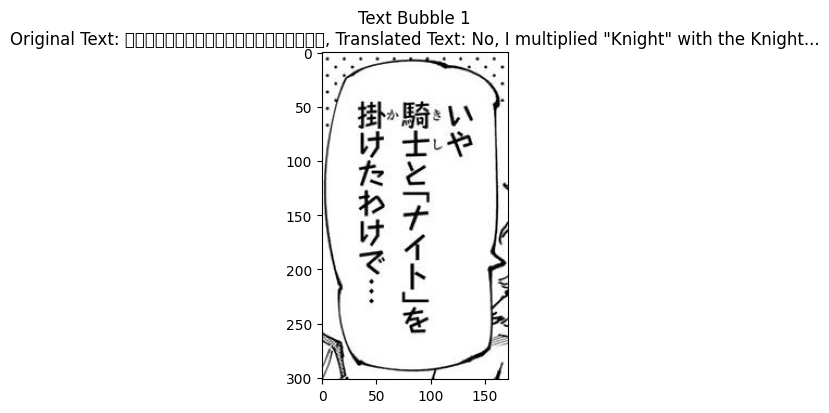

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12414 (\N{HIRAGANA LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12353 (\N{HIRAGANA LETTER SMALL A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12376 (\N{HIRAGANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24

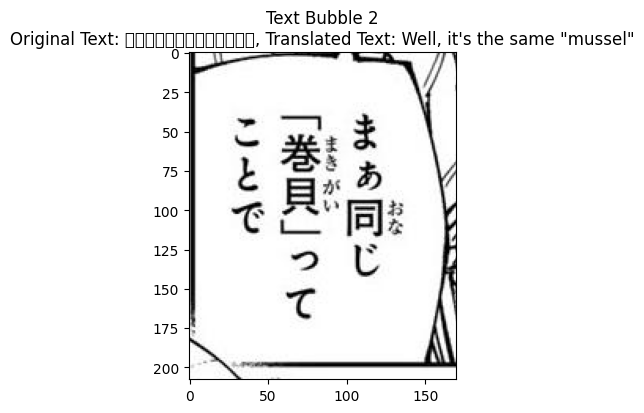

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25126 (\N{CJK UNIFIED IDEOGRAPH-6226}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarnin

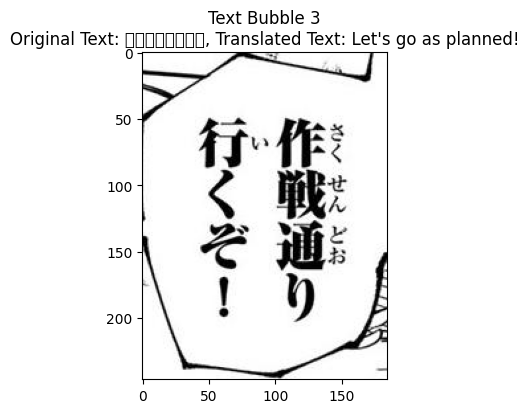

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12381 (\N{HIRAGANA LETTER SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12419 (\N{HIRAGANA LETTER SMALL YA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


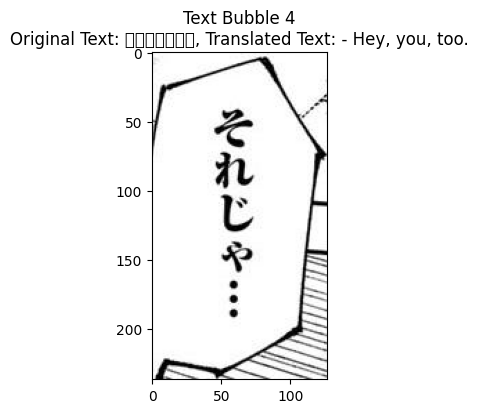

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


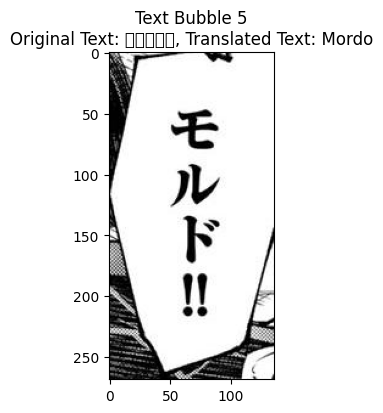

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22937 (\N{CJK UNIFIED IDEOGRAPH-5999}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12429 (\N{HIRAGANA LETTER RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12384 (

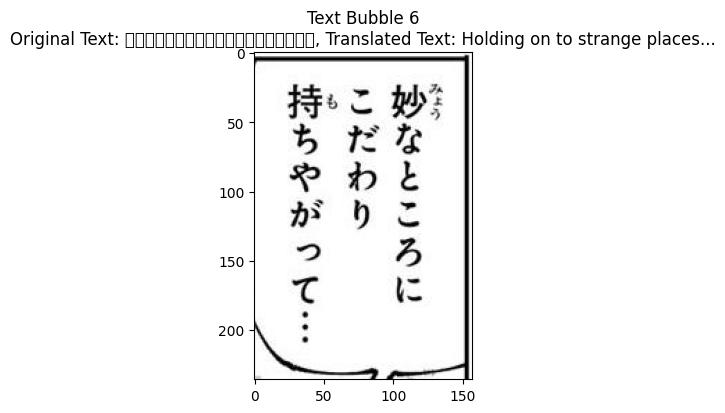

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12460 (\N{KATAKANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12363 (\N{HIRAGAN

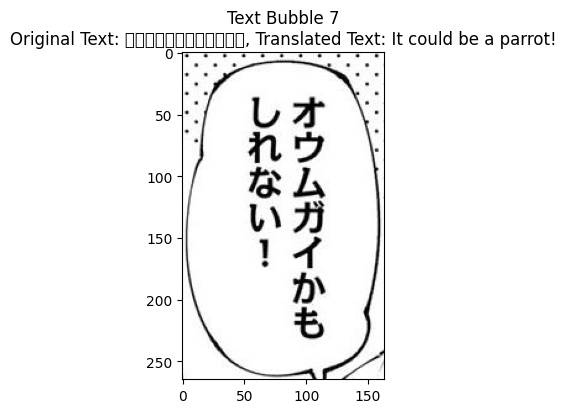

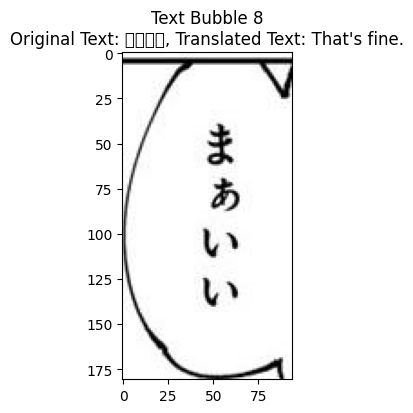

/home/mrcloud/anaconda3/envs/comitee/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


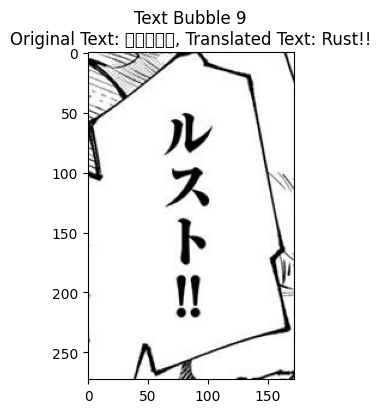

2024-03-05 13:10:45.147 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:10:51.316 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:10:53.494 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 567.0211181640625, 26.9727783203125, 738.8197021484375, 329.29534912109375
Text Bubble 1 - Original Text: いや騎士と「ナイト」を掛けたわけで．．．
Text Bubble 1 - Translated Text: No, I multiplied "Knight" with the Knight...
Text Bubble 1 - Googgle Translated Text: No, I put a knight with a knight...


2024-03-05 13:11:01.983 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:11:08.239 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:11:10.473 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 412.7431335449219, 308.4075927734375, 583.076171875, 515.8121337890625
Text Bubble 2 - Original Text: まぁ同じ「巻貝」ってことで
Text Bubble 2 - Translated Text: Well, it's the same "mussel"
Text Bubble 2 - Googgle Translated Text: Well, because it is the same "square"


2024-03-05 13:11:21.606 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:11:27.895 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:11:30.354 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 657.9058837890625, 980.5615234375, 843.2645263671875, 1228.233154296875
Text Bubble 3 - Original Text: 作戦通り行くぞ！
Text Bubble 3 - Translated Text: Let's go as planned!
Text Bubble 3 - Googgle Translated Text: I'm going as to the strategy!


2024-03-05 13:11:37.929 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:11:43.963 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:11:46.777 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 831.9631958007812, 909.8341064453125, 958.8056030273438, 1147.1998291015625
Text Bubble 4 - Original Text: それじゃ．．．
Text Bubble 4 - Translated Text: - Hey, you, too.
Text Bubble 4 - Googgle Translated Text: Well then...


2024-03-05 13:11:52.901 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:11:59.162 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:12:01.129 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 415.7864990234375, 1257.97412109375, 551.7606201171875, 1526.5615234375
Text Bubble 5 - Original Text: モルド！！
Text Bubble 5 - Translated Text: Mordo
Text Bubble 5 - Googgle Translated Text: Mold!!


2024-03-05 13:12:08.269 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:12:14.577 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:12:16.983 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 246.732666015625, 106.63381958007812, 404.0616455078125, 343.492431640625
Text Bubble 6 - Original Text: 妙なところにこだわり持ちやがって．．．
Text Bubble 6 - Translated Text: Holding on to strange places...
Text Bubble 6 - Googgle Translated Text: I am particular about strange places...


2024-03-05 13:12:25.170 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:12:31.271 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:12:33.288 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 844.306884765625, 15.11761474609375, 1008.1627197265625, 279.70526123046875
Text Bubble 7 - Original Text: オウムガイかもしれない！
Text Bubble 7 - Translated Text: It could be a parrot!
Text Bubble 7 - Googgle Translated Text: It may be a parrot!


2024-03-05 13:12:40.790 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:12:47.198 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:12:50.523 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 152.15106201171875, 107.47100830078125, 245.60333251953125, 288.16204833984375
Text Bubble 8 - Original Text: まぁいい
Text Bubble 8 - Translated Text: That's fine.
Text Bubble 8 - Googgle Translated Text: Well


2024-03-05 13:13:00.400 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2024-03-05 13:13:06.588 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-03-05 13:13:09.590 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


Coordinates: 505.0067138671875, 1158.51611328125, 677.3712158203125, 1432.2177734375
Text Bubble 9 - Original Text: ルスト！！
Text Bubble 9 - Translated Text: Rust!!
Text Bubble 9 - Googgle Translated Text: Rost!!
Changes not saved. Exiting without saving.


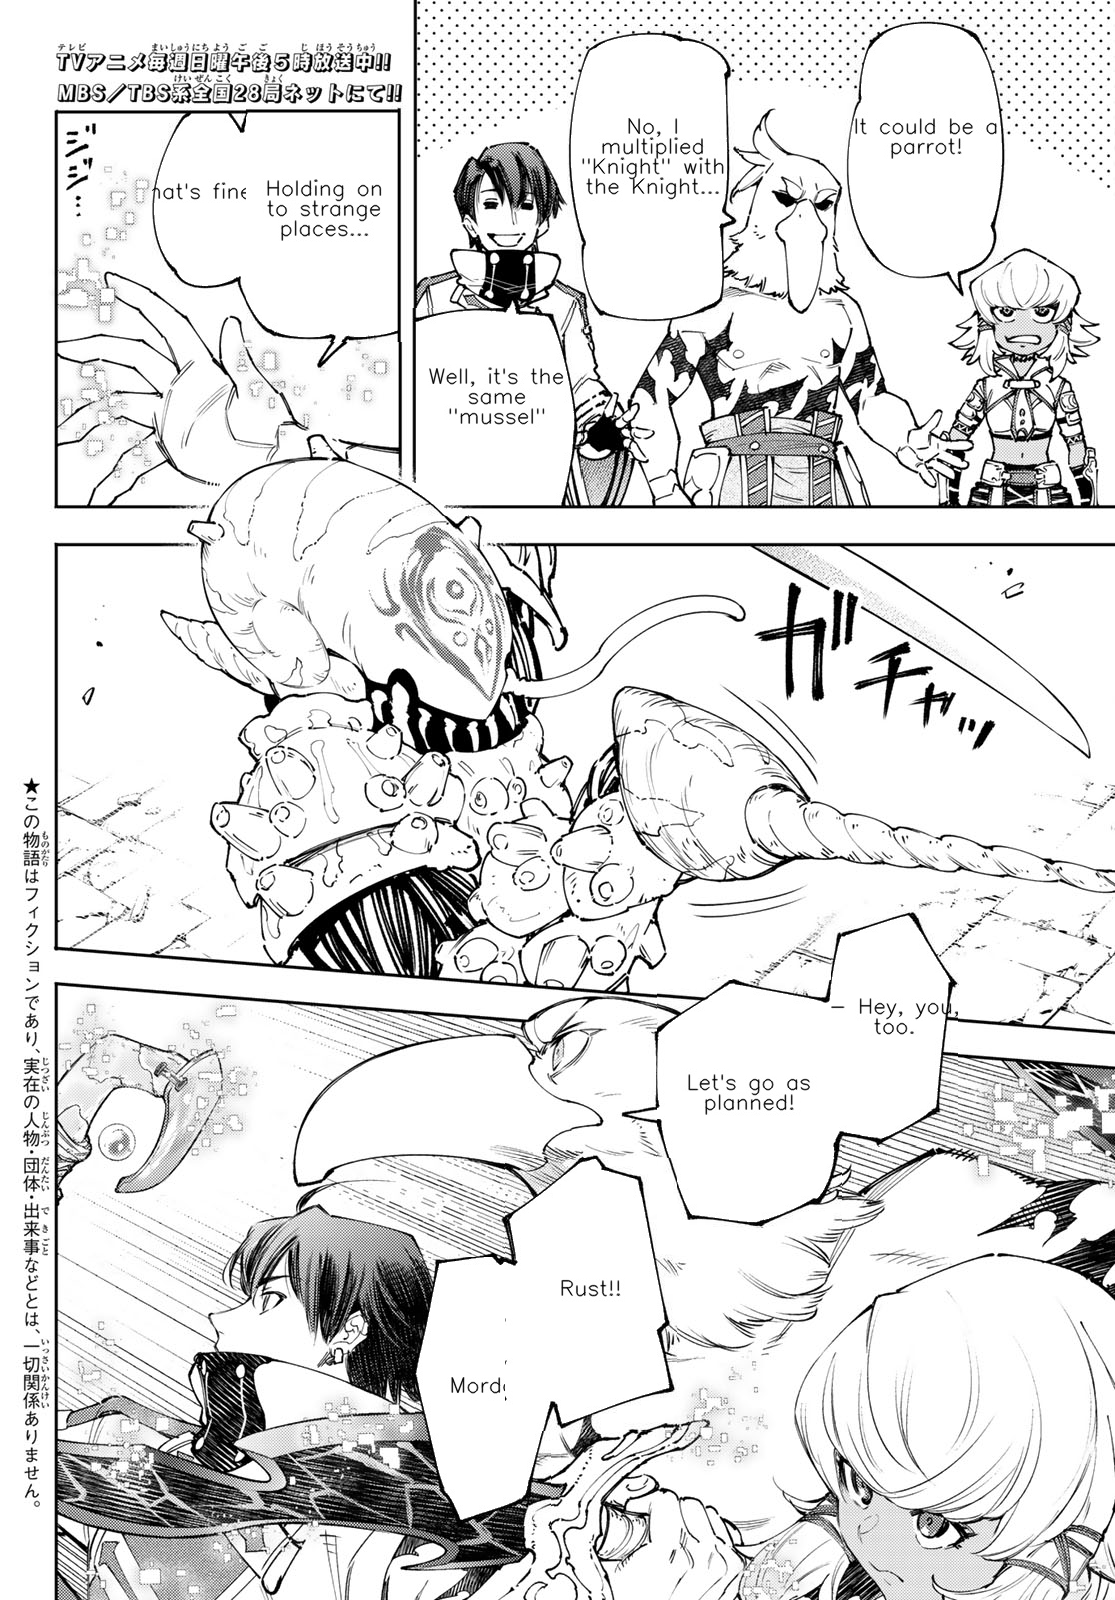

In [9]:

# Initialize an empty image to accumulate overlays
output_image = None

def process_all_images(input_image_path, output_folder='text_bubbles'):
    global output_image  # Use the global variable

    # Load YOLO model for text bubble detection
    text_bubble_detector = YOLO('best-detection.pt')

    # Clean up the output folder and main output image before running
    clean_up_output_folder(output_folder)
    clean_up_main_output_image('output_image.jpg')
    clean_up_translated_text_images(os.getcwd())
    clean_up_original_text_images(os.getcwd())

    # Open the input image
    input_image = Image.open(input_image_path)

    # Initialize output_image if not already initialized
    if output_image is None:
        output_image = np.array(input_image)

    # Perform text bubble detection
    detections = text_bubble_detector(input_image)
    text_bubble_boxes = detections[0].boxes.data.cpu().numpy()

    # Save and display all text bubbles at once
    for i, box in enumerate(text_bubble_boxes):
        x1, y1, x2, y2, _, _ = box
        # cv2.rectangle(input_image,(x1,y1),(x2,y2),(255,0,0,),1)

        text_bubble_filename = os.path.join(output_folder, f'text_bubble_{i}.jpg')

        # Crop and save each text bubble
        text_bubble = input_image.crop((x1, y1, x2, y2))
        text_bubble.save(text_bubble_filename)

    # Display all text bubbles at once
    for i, box in enumerate(text_bubble_boxes):
        x1, y1, x2, y2, _, _ = box
        text_bubble_filename = os.path.join(output_folder, f'text_bubble_{i}.jpg')

        # Translate Japanese text to English
        mocr = MangaOcr()
        original_text = mocr(text_bubble_filename)
        translated_text = translate_japanese_to_english(original_text)

        # Display the original and translated text bubbles separately
        plt.figure(figsize=(15, 5 * len(text_bubble_boxes)))

        plt.subplot(len(text_bubble_boxes), 2, 2 * i + 1)
        img = Image.open(text_bubble_filename)
        plt.imshow(img)
        plt.title(f'Text Bubble {i + 1}\nOriginal Text: {original_text}, Translated Text: {translated_text[0]}')

        # plt.subplot(len(text_bubble_boxes), 2, 2 * i + 2)
        # plt.imshow(img)
        # plt.title(f'Translated Text: {translated_text}')

    plt.show()

    # Process user input for each text bubble
    for i, box in enumerate(text_bubble_boxes):
        x1, y1, x2, y2, _, _ = box
        text_bubble_filename = os.path.join(output_folder, f'text_bubble_{i}.jpg')
    
        # Translate Japanese text to English
        mocr = MangaOcr()
        original_text = mocr(text_bubble_filename)
        translated_text = translate_japanese_to_english(original_text)
    
        # Display the original and translated text
        print(f'Coordinates: {x1}, {y1}, {x2}, {y2}')
        print(f'Text Bubble {i + 1} - Original Text: {original_text}')
        print(f'Text Bubble {i + 1} - Translated Text: {translated_text[0]}')
        print(f'Text Bubble {i + 1} - Googgle Translated Text: {translated_text[1]}')

    
        # Prompt the user to choose whether to keep the original or overlay the translated text
        while True:
            try:
                user_choice = input(f"Do you want to keep the original text bubble {i+1}? (yes/no): ").lower()
                if user_choice in ['yes', 'no']:
                    break
                else:
                    raise ValueError("Invalid input. Please enter 'yes' or 'no'.")
            except ValueError as e:
    
                print(e)
        if user_choice == 'no':
            # Process the image with contours and overlay the translated text
            output_image_path = f'translated_text_{i}.jpg'
            output_google_image_path = f'translated_google_text_{i}.jpg'
            # print("Translated text : :   ",translated_text)

            process_image_with_contours(text_bubble_filename, output_image_path, translated_text[0])
            process_image_with_contours(text_bubble_filename, output_google_image_path, translated_text[1])

    
            # Overlay the translated text onto the original image
            overlay_images(output_image, output_image_path, (x1, y1))
        else:
            # Keep the original text bubble
            output_image_path = f'original_text_{i}.jpg'
            output_google_image_path = f'translated_google_text_{i}.jpg'
            process_image_with_contours(text_bubble_filename, output_image_path, translated_text[0])
            process_image_with_contours(text_bubble_filename, output_google_image_path, translated_text[1])


    # Ask for confirmation before saving the final image
    while True:
        try:
            user_confirmation = input("Do you want to save the final image with all changes? (yes/no): ").lower()
            if user_confirmation in ['yes', 'no']:
                break
            else:
                raise ValueError("Invalid input. Please enter 'yes' or 'no'.")
        except ValueError as e:
            print(e)

    if user_confirmation == 'yes':
        # Save the final result
        cv2.imwrite('output_image.jpg', output_image)
        print("Final image saved successfully!")
    else:
        print("Changes not saved. Exiting without saving.")

    # Display the final result
    display_image(output_image)


if __name__ == "__main__":
    # Specify the input image path
    input_image_path = 'img/shangrila_168/2.jpg'

    # Perform text bubble detection and processing for all images
    process_all_images(input_image_path)

    


In [12]:
import session_info
session_info.show()

'Well, because it is the same "square"'